In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from rdkit import Chem
from rdkit.Chem import Draw


matplotlib.rcdefaults()
sns.set_style("darkgrid")
plt.rcParams["figure.dpi"] = 144

pd.set_option("display.max_columns", None)

In [2]:
def sdf_to_df(args):
    """
    Load molecules and their properties from an SDF file into a DataFrame.

    Example usage: df=sdf_to_df(("./ADRB1/docking/ADRB1_active_docking_lib.sdf", "active"))

    Note that this function was originally intended to be used with the `multiprocessing` module, so the arguments are passed as a tuple.

    Will likely be updated later.

    """
    file, active_status = args  # Unpack the tuple of arguments

    # Create a molecule supplier
    mol_supplier = Chem.MultithreadedSDMolSupplier(file, numWriterThreads=8)

    # Load the molecules and their properties into a list
    molecules = []
    first_mol = True
    for mol in mol_supplier:
        if mol is not None:
            if first_mol:
                # Get properties as dictionary only for the first molecule
                props = mol.GetPropsAsDict()
                keys = props.keys()
                first_mol = False
            else:
                # For the rest of the molecules, get properties directly
                props = {key: mol.GetProp(key) for key in keys if mol.HasProp(key)}

            props["Title"] = mol.GetProp("_Name")
            props["Mol"] = mol
            props["Activity"] = 1 if active_status == "active" else 0
            molecules.append(props)

    # Convert the list into a DataFrame
    df = pd.DataFrame(molecules)

    # Reorder the DataFrame columns
    cols = ["Title", "Mol", "Activity"] + [
        col for col in df.columns if col not in ["Title", "Mol", "Activity"]
    ]
    df = df[cols]
    df = df.rename(columns={"Title": "Molecule_Name"})

    # Convert 'r_i_docking_score' to numeric, coercing errors to NaN
    df["r_i_docking_score"] = pd.to_numeric(df["r_i_docking_score"], errors="coerce")

    # Print 'Molecule_Name' and 'r_i_docking_score' for entries that could not be converted
    non_convertible_entries = df[df["r_i_docking_score"].isna()]
    for _, row in non_convertible_entries.iterrows():
        print(
            f"Molecule_Name: {row['Molecule_Name']}, r_i_docking_score: {row['r_i_docking_score']}"
        )

    # Drop rows with non-convertible 'r_i_docking_score'
    df = df.dropna(subset=["r_i_docking_score"])

    # Convert 'r_i_docking_score' to int64
    df["r_i_docking_score"] = df["r_i_docking_score"].astype("float64")

    return df

In [3]:
adrb1_active = sdf_to_df(("./ADRB1/docking/ADRB1_active_docking_lib_sorted.sdf", "active"))
adrb1_decoy = sdf_to_df(("./ADRB1/docking/ADRB1_decoy_docking_lib_sorted.sdf", "inactive"))

In [8]:
duplicates_actives = adrb1_active['Molecule_Name'].duplicated()
print(any(duplicates_actives))
duplicates_decoys = adrb1_decoy['Molecule_Name'].duplicated()
print(any(duplicates_decoys))

False
False


In [9]:
# from old code, probably fine but not optimal
def concatenate_csv_files(file_list):
    """
    Concatenates multiple strain CSV files into a single dataframe.
    Only the first five columns are kept for now.

    Args:
        file_list (list): A list of file paths to the CSV files.

    Returns:
        pandas.DataFrame: The concatenated dataframe.

    """
    # Specify the column names
    column_names = [
        "Molecule_Name",
        "Total_E",
        "Lower_Bound",
        "Upper_Bound",
        "Num_Torsion_Patterns",
    ]

    # List to hold dataframes
    df_list = []

    # Loop over each file in the list
    for file in file_list:
        # Import the CSV file as a df, using only the first five columns of the CSV file
        df = pd.read_csv(file, usecols=range(5), names=column_names, header=0)
        df_list.append(df)

    # Concatenate all dataframes in the list
    final_df = pd.concat(df_list, ignore_index=True)

    return final_df

In [10]:
adrb1_active_strain_df = concatenate_csv_files(
    ["./ADRB1/strain/ADRB1_active_docking_lib_sorted.csv"]
)
adrb1_decoy_strain_df = concatenate_csv_files(
    ["./ADRB1/strain/ADRB1_decoy_docking_lib_sorted.csv"]
)


In [12]:
duplicates_actives = adrb1_active_strain_df['Molecule_Name'].duplicated()
print(any(duplicates_actives))
duplicates_decoys = adrb1_decoy_strain_df['Molecule_Name'].duplicated()
print(any(duplicates_decoys))

False
False


In [13]:
pre_merge = [adrb1_active, adrb1_active_strain_df, adrb1_decoy, adrb1_decoy_strain_df]

for df in pre_merge:
    print(df.shape)

(286, 33)
(285, 5)
(11621, 33)
(11620, 5)


In [14]:
adrb1_active_data=pd.merge(adrb1_active, adrb1_active_strain_df, on='Molecule_Name')
adrb1_decoy_data=pd.merge(adrb1_decoy, adrb1_decoy_strain_df, on='Molecule_Name')

In [15]:
post_merge = [adrb1_active_data, adrb1_decoy_data]

for df in post_merge:
    print(df.shape)

(285, 37)
(11620, 37)


In [16]:
adrb1_all_data = pd.concat([adrb1_active_data, adrb1_decoy_data])

print(adrb1_all_data.shape)

(11905, 37)


In [19]:
def plot_density(df, title_suffix):
  # Hardcoded column names
  activity_col = 'Activity'
  score_col = 'r_i_docking_score'

  # Create a density plot for the score of active and inactive molecules
  sns.kdeplot(df.loc[df[activity_col] == 0, score_col], label='Inactive', fill=True)
  sns.kdeplot(df.loc[df[activity_col] == 1, score_col], label='Active', fill=True)

  # Add title and labels
  plt.title(f'Density Plot of Docking Score for Active and Decoy Molecules ({title_suffix})')
  plt.xlabel('Docking Score')
  plt.ylabel('Density')
  plt.legend(loc='best')

  # Show the plot
  plt.show()

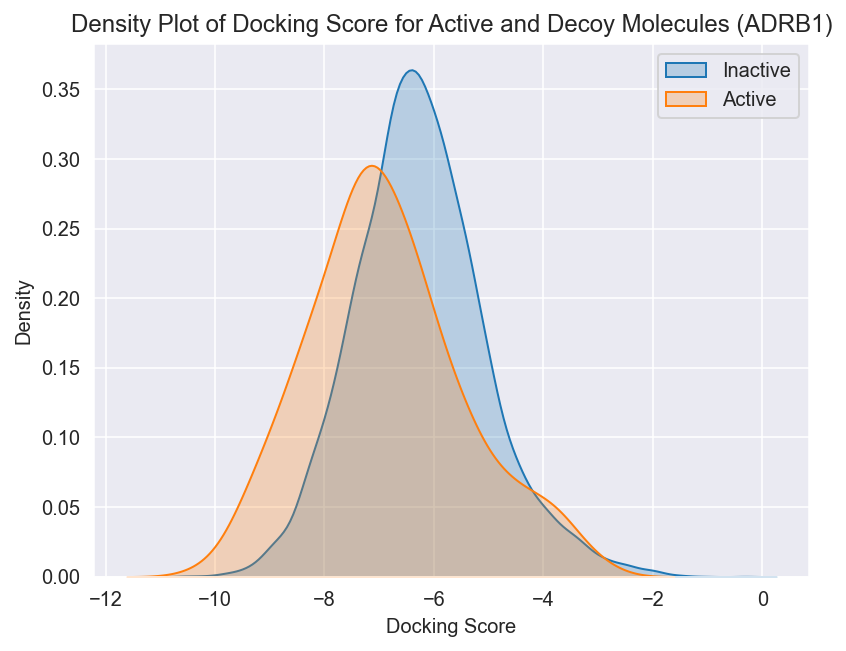

In [21]:
plot_density(adrb1_all_data, "ADRB1")

In [22]:
def calculate_enrichment_parameters(df):
    """
    Calculates parameters we will need for Enrichment Plots

    Parameters:
    df (pandas.DataFrame): The dataframe to calculate the logAUC for.

    Returns:
    pandas.DataFrame: The dataframe with the logAUC calculated.
    """
    # Sort the subset by 'r_i_docking_score' in ascending order
    df.sort_values(by="r_i_docking_score", inplace=True)

    # Reset the index so that we are ranking by the docking score
    df.reset_index(drop=True, inplace=True)

    # Adjusting the index to start from 1
    df.index += 1

    # Calculate the cumulative sum of active compounds
    df["Cumulative_Actives"] = df["Activity"].cumsum()

    # Calculate the Total Actives
    df["Total_Actives"] = df["Activity"].sum()

    # Calculate the fraction of identified actives at each row
    df["Fraction_Actives"] = df["Cumulative_Actives"] / df["Total_Actives"]

    # Calculate the percentage of compounds screened at each row
    df["Percentage_Screened"] = df.index / len(df)

    return df

In [23]:
calculate_enrichment_parameters(adrb1_all_data)

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened
1,C63708483_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x149c99b60>,0,ADRB1_chembl19_set_decoy_sc.smi,5833,53161,0,S-OPLS,54.0193,1,C63708483_Isomer1-1,ADRB1,5832,12,-10.606600,-0.27912,-0.938395,-2.28709,-10.6066,-3.35059,-0.802551,-0,-1.64557,-56.0264,-17.6283,0.737216,-0.0995119,-124.272,-73.6547,5.28155,299,162,0,12.286906,10.119211,NaN,7,0,285,0.000000,0.000084
2,C15446699_Isomer2,<rdkit.Chem.rdchem.Mol object at 0x149c99d20>,0,ADRB1_chembl19_set_decoy_sc.smi,1244,53161,0,S-OPLS,57.847,1,C15446699_Isomer2-1,ADRB1,1243,13,-10.501700,-0.30005,-0.981482,-2.30536,-10.5017,-3.46201,-0.482909,-0,-2.50489,-54.958,-12.1792,0.653844,-0.130999,-115.198,-67.1372,9.29601,26,148,0,12.879092,10.862930,inf,5,0,285,0.000000,0.000168
3,C20168010_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x149c99cb0>,0,ADRB1_chembl19_set_decoy_sc.smi,6370,53161,0,S-OPLS,47.3955,1,C20168010_Isomer1-1,ADRB1,6369,12,-10.254900,-0.310753,-0.996752,-2.28063,-10.2549,-3.97289,-0.788917,-0,-1.03409,-55.4296,-16.1753,0.741446,-0.00264788,-115.786,-71.6048,7.0869,108,174,0,13.005273,10.361206,NaN,4,0,285,0.000000,0.000252
4,carmoterol_Isomer4,<rdkit.Chem.rdchem.Mol object at 0x149be1af0>,1,ADRB1_chembl19_set_active_sc.smi,7,53161,0,S-OPLS,41.8524,1,carmoterol_Isomer4-1,ADRB1,6,9,-10.237900,-0.379181,-1.13754,-2.38321,-10.2379,-3.05431,-0.629243,-0,-2.84392,-43.1217,-13.798,0.59334,-0.0779635,-103.922,-56.9198,3.71715,17,1,0,2.287672,2.029271,2.576365,4,1,285,0.003509,0.000336
5,C23259752_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x149c99c40>,0,ADRB1_chembl19_set_decoy_sc.smi,2996,53161,0,S-OPLS,43.564,1,C23259752_Isomer1-1,ADRB1,2995,9,-10.183400,-0.308589,-0.989809,-2.26474,-10.1834,-3.50106,-0.849263,-0,-1.77267,-53.0985,-13.5325,0.691707,-0.0673426,-108.302,-66.631,9.11678,86,369,0,10.094817,8.084260,NaN,7,1,285,0.003509,0.000420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11901,C73803375_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x1762822d0>,0,ADRB1_chembl19_set_decoy_sc.smi,11344,53161,0,S-OPLS,29.9424,1,C73803375_Isomer1-1,ADRB1,11343,8,-1.492570,-0.0710746,-0.19609,-0.369034,-1.49257,-1.23759,0,-0,-1.72909,-26.6027,-0.649064,2.93586,-0.034253,-30.839,-27.2518,1.22089,4,189,0,4.917013,4.407562,5.560015,0,285,285,1.000000,0.999664
11902,C49229239_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x176282260>,0,ADRB1_chembl19_set_decoy_sc.smi,5038,53161,0,S-OPLS,25.6059,1,C49229239_Isomer1-1,ADRB1,5037,12,-1.470560,-0.0735278,-0.199585,-0.368032,-1.47056,-1.08607,-0.135538,-0,-1.92198,-30.6279,-4.77582,4.00928,-0.0884848,-35.4171,-35.4037,6.44646,33,252,0,15.170713,12.091766,NaN,0,285,285,1.000000,0.999748
11903,C70538242_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x176282340>,0,ADRB1_chembl19_set_decoy_sc.smi,9113,53161,0,S-OPLS,9.53065,1,C70538242_Isomer1-1,ADRB1,9112,10,-1.451680,-0.0764041,-0.203877,-0.368032,-1.45168,-1.05567,-0.152,-0,-2.15674,-27.7964,-6.89188,4.43201,-0.0956744,-37.3521,-34.6882,1.83846,185,237,0,4.415769,4.135538,4.727666,5,285,285,1.000000,0.999832
11904,C74546931_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x1762823b0>,0,ADRB1_chembl19_set_decoy_sc.smi,9118,53161,0,S-OPLS,26.0528,1,C74546931_Isomer1-1,ADRB1,9117,10,-1.0

In [24]:
def plot_enrichment_curve(df, title_suffix):
    """
    Plots the enrichment curve for a dataframe.

    Parameters:
    df (pandas.DataFrame): The dataframe to plot the enrichment curve for.
    title_suffix (str): The suffix to add to the title of the plot.

    Returns:
    None
    """
    enrichment_auc = auc(df["Percentage_Screened"], df["Fraction_Actives"])

    plt.plot(
        df["Percentage_Screened"] * 100,
        df["Fraction_Actives"],
        label="Enrichment AUC = {:.2f}".format(enrichment_auc),
    )

    # Add axis labels and title
    plt.xlabel("Compounds Screened (%)")
    plt.ylabel("Fraction of Identified Actives")
    plt.title(f"Enrichment Curve ({title_suffix})")

    plt.legend()
    plt.show()

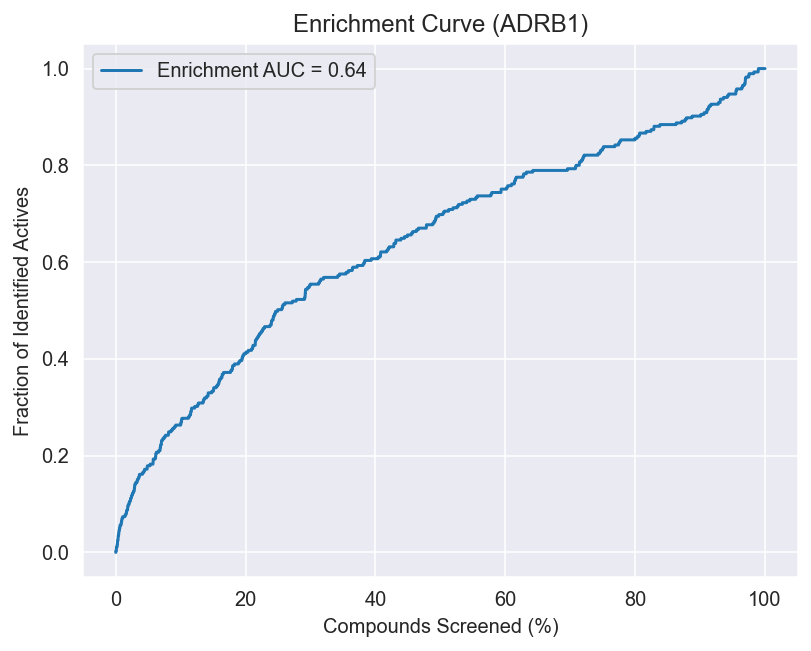

In [25]:
plot_enrichment_curve(adrb1_all_data, "ADRB1")

In [30]:
def plot_roc_curve_inverted(y_true, y_scores, title_suffix):
  """
  Plot the ROC curve for the given true labels and inverted scores.

  :param y_true: The true binary labels.
  :param y_scores: The predicted scores where lower scores indicate positive class.
  :param title_suffix: The suffix to add to the title of the plot.
  """
  # Inverting the scores
  y_scores_inverted = -y_scores

  # Compute the ROC curve and AUC with inverted scores
  fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
  roc_auc = auc(fpr, tpr)

  # Plotting the ROC curve
  plt.plot(fpr, tpr, lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
  plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(f"Receiver Operating Characteristic (Inverted Scores) ({title_suffix})")
  plt.legend(loc="best")
  plt.show()

In [34]:
def plot_roc_curve_inverted(y_true, y_scores, title_suffix):
    """
    Plot the ROC curve for the given true labels and inverted scores.

    :param y_true: The true binary labels.
    :param y_scores: The predicted scores where lower scores indicate positive class.
    :param title_suffix: The suffix to add to the title of the plot.
    """
    # Inverting the scores
    y_scores_inverted = -y_scores

    # Compute the ROC curve and AUC with inverted scores
    fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], lw=2, linestyle="--", label="Random Classifier")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver Operating Characteristic (Inverted Scores) ({title_suffix})")
    plt.legend(loc="best")
    plt.show()

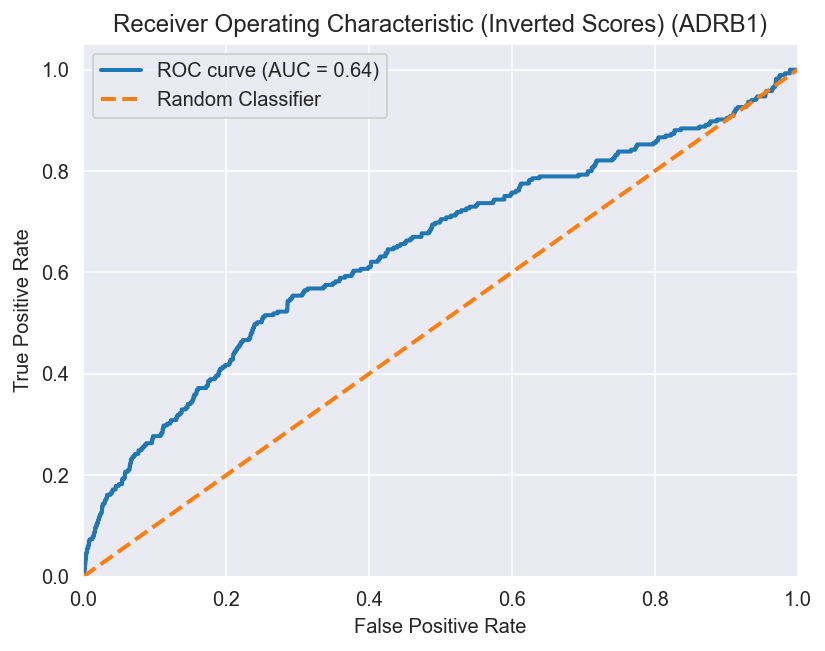

In [35]:
plot_roc_curve_inverted(adrb1_all_data["Activity"], adrb1_all_data["r_i_docking_score"], "ADRB1")

AUC for the original ROC curve: 0.5
AUC for the log-transformed ROC curve: 0.9982936817079362
Range of Log FPR: -6.907755278982137 to 0.0009995003330834232
LogAUC for the log-transformed ROC curve: 0.14451781242821266


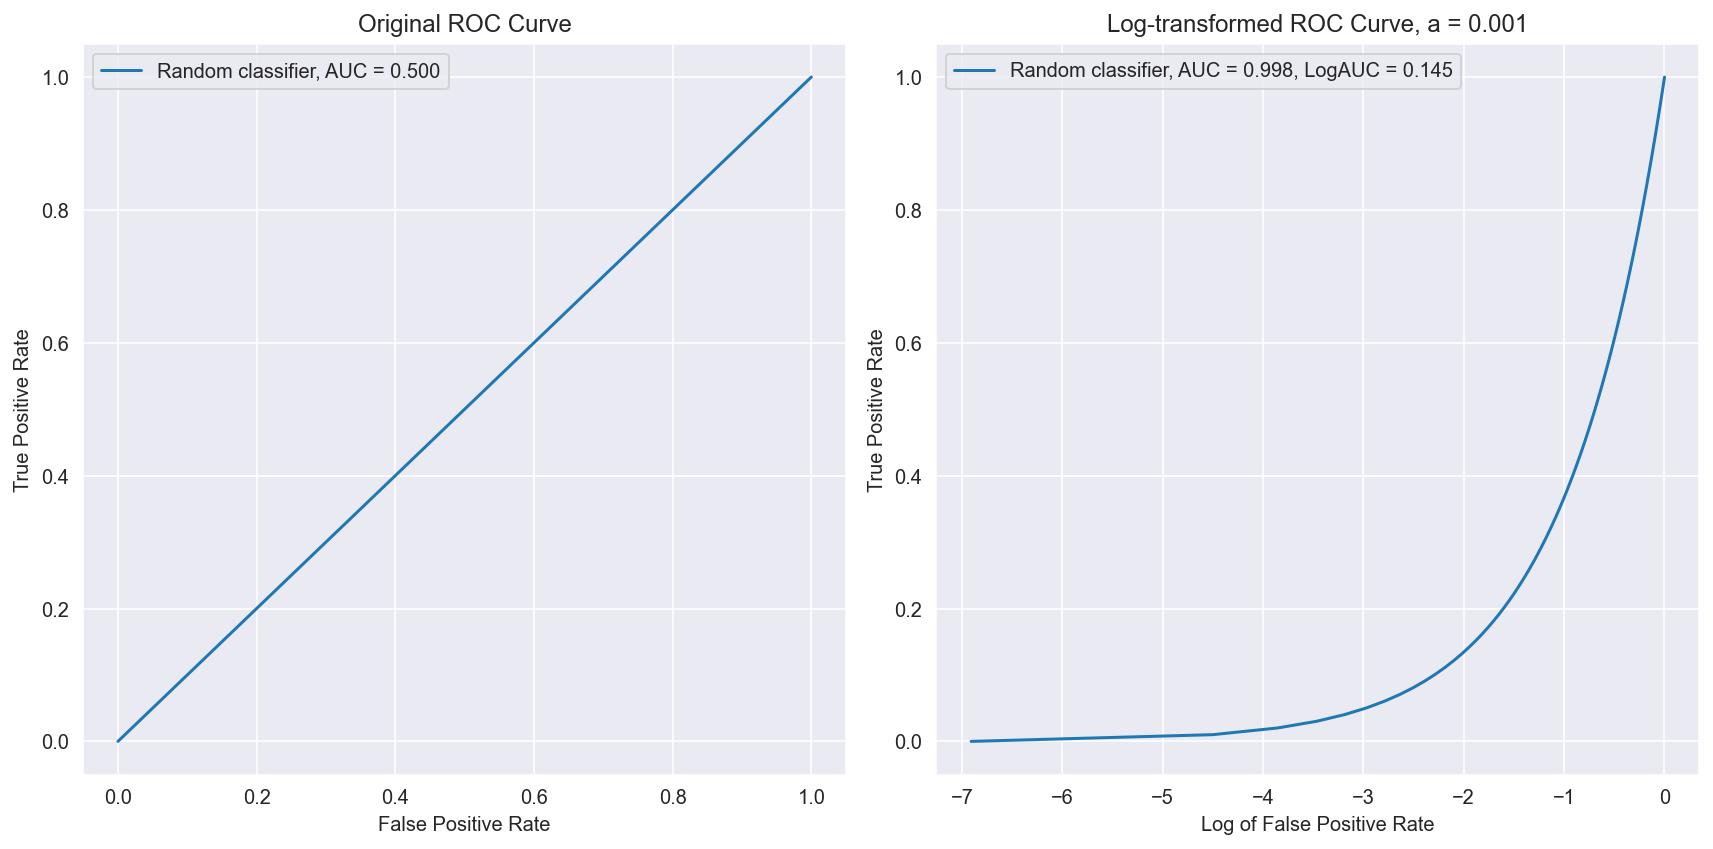

In [42]:
# Define the points
x_values_random_class = np.linspace(0, 1, 100)
y_values_random_class = x_values_random_class  # For a random classifier, the true positive rate equals the false positive rate

# Define a small constant
a = 1e-3

# Apply a logarithmic transformation to the x values
x_values_log = np.log(x_values_random_class + a)

# Calculate the AUC for the original ROC curve
auc_original = auc(x_values_random_class, y_values_random_class)
print(f"AUC for the original ROC curve: {auc_original}")

# Calculate the AUC for the log-transformed ROC curve
auc_transformed = auc(x_values_log, y_values_random_class)
print(f"AUC for the log-transformed ROC curve: {auc_transformed}")
print(f"Range of Log FPR: {np.min(x_values_log)} to {np.max(x_values_log)}")

# Calculate the LogAUC for the log-transformed ROC curve
log_auc_transformed = auc_transformed / -np.log(a)
print(f"LogAUC for the log-transformed ROC curve: {log_auc_transformed}")

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original ROC curve on the first subplot
axs[0].plot(
    x_values_random_class,
    y_values_random_class,
    label=f"Random classifier, AUC = {auc_original:.3f}",
)
axs[0].set_title("Original ROC Curve")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend(loc="best")
axs[0].grid(True)

# Plot the transformed ROC curve on the second subplot
axs[1].plot(
    x_values_log,
    y_values_random_class,
    label=f"Random classifier, AUC = {auc_transformed:.3f}, LogAUC = {log_auc_transformed:.3f}",
)
axs[1].set_title(f"Log-transformed ROC Curve, a = {a}")
axs[1].set_xlabel("Log of False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].legend(loc="best")
axs[1].grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [56]:
def plot_linlog10_roc_curve(df, title_suffix, a=1e-3):
  # Invert scores since lower scores indicate positive class
  y_scores_inverted = -df["r_i_docking_score"]

  # Calculate FPR, TPR, and thresholds using sklearn
  fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

  # Select the thresholds that result in FPR >= a for log scale plotting
  valid_indices = np.where(fpr >= a)
  fpr_valid = fpr[valid_indices]
  tpr_valid = tpr[valid_indices]

  # Calculate log of FPR for valid indices
  log_fpr_valid = np.log10(fpr_valid)

  # Calculate the AUC for the valid range
  linlog_auc = auc(log_fpr_valid, tpr_valid)
  log_auc = linlog_auc / -np.log10(a)

  # Plot the ROC curve
  plt.plot(
    log_fpr_valid,
    tpr_valid,
    color="blue",
    label=f"ROC Curve ({title_suffix}), LogAUC = {log_auc:.3f}, a = {a}",
  )

  # Define the points for the random classifier
  x_values_random_class = np.linspace(a, 1, 100)
  y_values_random_class = x_values_random_class  # For a random classifier, the true positive rate equals the false positive rate

  # Apply a logarithmic transformation to the x values
  x_values_log = np.log10(x_values_random_class)

  # Calculate the AUC for the random classifier
  linlog_auc_random = auc(x_values_log, y_values_random_class)
  log_auc_random = linlog_auc_random / -np.log10(a)

  # Plot the ROC curve for the random classifier
  plt.plot(
    x_values_log,
    y_values_random_class,
    color="red",
    linestyle="--",
    label=f"Random Classifier, LogAUC = {log_auc_random:.3f}, a = {a}",
  )

  plt.xlim([np.log10(a), 0])
  plt.ylim([0, 1])
  plt.xlabel("Log (False Positive Rate)")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="upper left")
  plt.title(f"Linear Log10 ROC Curve ({title_suffix})")
  plt.show()

  # print(
  #   f"Range of integration in linlog_auc: {log_fpr_valid[0]} to {log_fpr_valid[-1]}"
  # )
  # print(f"Value of linglog_auc: {linlog_auc}")
  # print(f"Value of log_auc: {log_auc}")
  # print(f"Value of linglog_auc for random classifier: {linlog_auc_random}")
  # print(f"Value of log_auc for random classifier: {log_auc_random}")

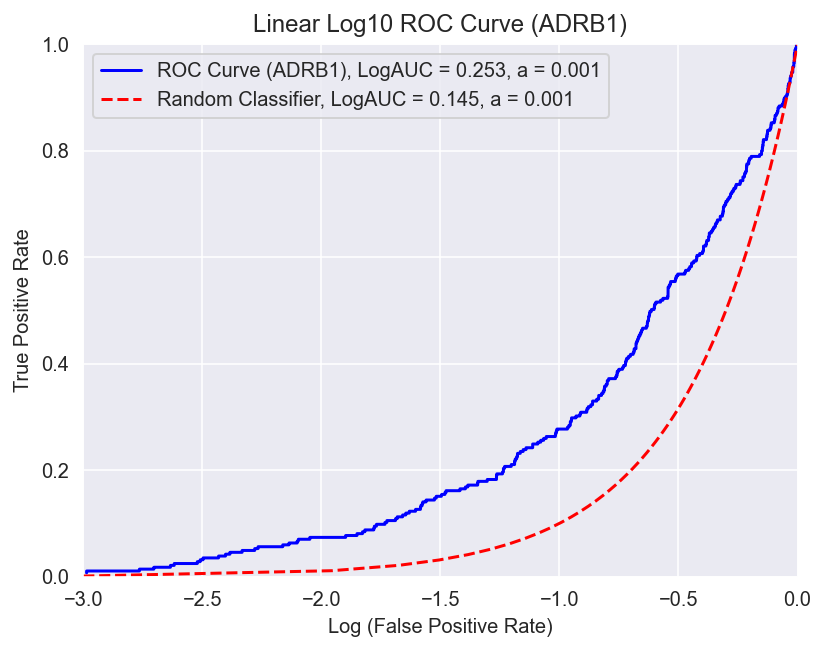

In [57]:
plot_linlog10_roc_curve(adrb1_all_data, "ADRB1")

Now we need to evaluate the impact of strain filtering. We will set thresholds to cut off the data like their paper did. Then, we will plot both the change in performance by logAUC, and then the Linear LogAUC for the thresholds.

In [60]:
total_e_thresholds = [None, 4, 4.5, 5.0, 5.5, 6.0, 7.0, 7.5, 8.0]

In [97]:
def logauc_by_strain(df, a=1e-3, total_e_threshold=None):
    # Filter dataframe based on 'Total_E' threshold if provided
    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    # Invert scores since lower scores indicate positive class
    y_scores_inverted = -df["r_i_docking_score"]

    # Calculate FPR, TPR, and thresholds using sklearn
    fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

    # Select the thresholds that result in FPR >= a for log scale plotting
    valid_indices = np.where(fpr >= a)
    fpr_valid = fpr[valid_indices]
    tpr_valid = tpr[valid_indices]

    # Calculate log of FPR for valid indices
    log_fpr_valid = np.log10(fpr_valid)

    # Calculate the AUC for the valid range
    linlog_auc = auc(log_fpr_valid, tpr_valid)
    log_auc = (linlog_auc / -np.log10(a)) * 100

    return log_auc

In [98]:
def plot_log_aucs(data, thresholds, title_suffix):
    # Calculate log_auc for each threshold and plot
    log_aucs = [logauc_by_strain(data, total_e_threshold=t) for t in thresholds]
    
    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]
    
    plt.bar(range(len(thresholds)), log_aucs, tick_label=x_labels)
    plt.title(f"Linear Log10 AUC by Strain Energy Cutoff ({title_suffix})")
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Delta Linear Log10 AUC (x100)")
    plt.show()

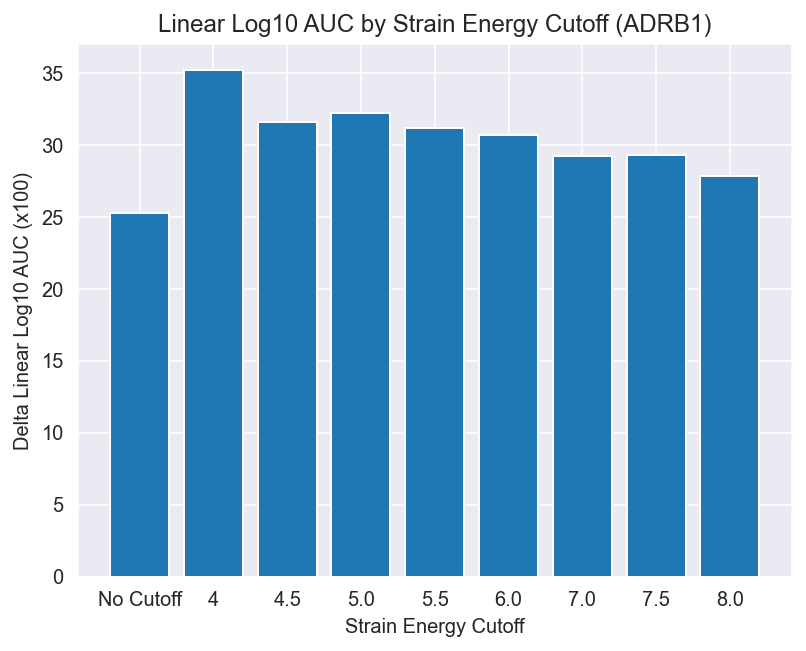

In [99]:
plot_log_aucs(adrb1_all_data, total_e_thresholds, "ADRB1")

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_43724/3473154569.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(total_e_thresholds))


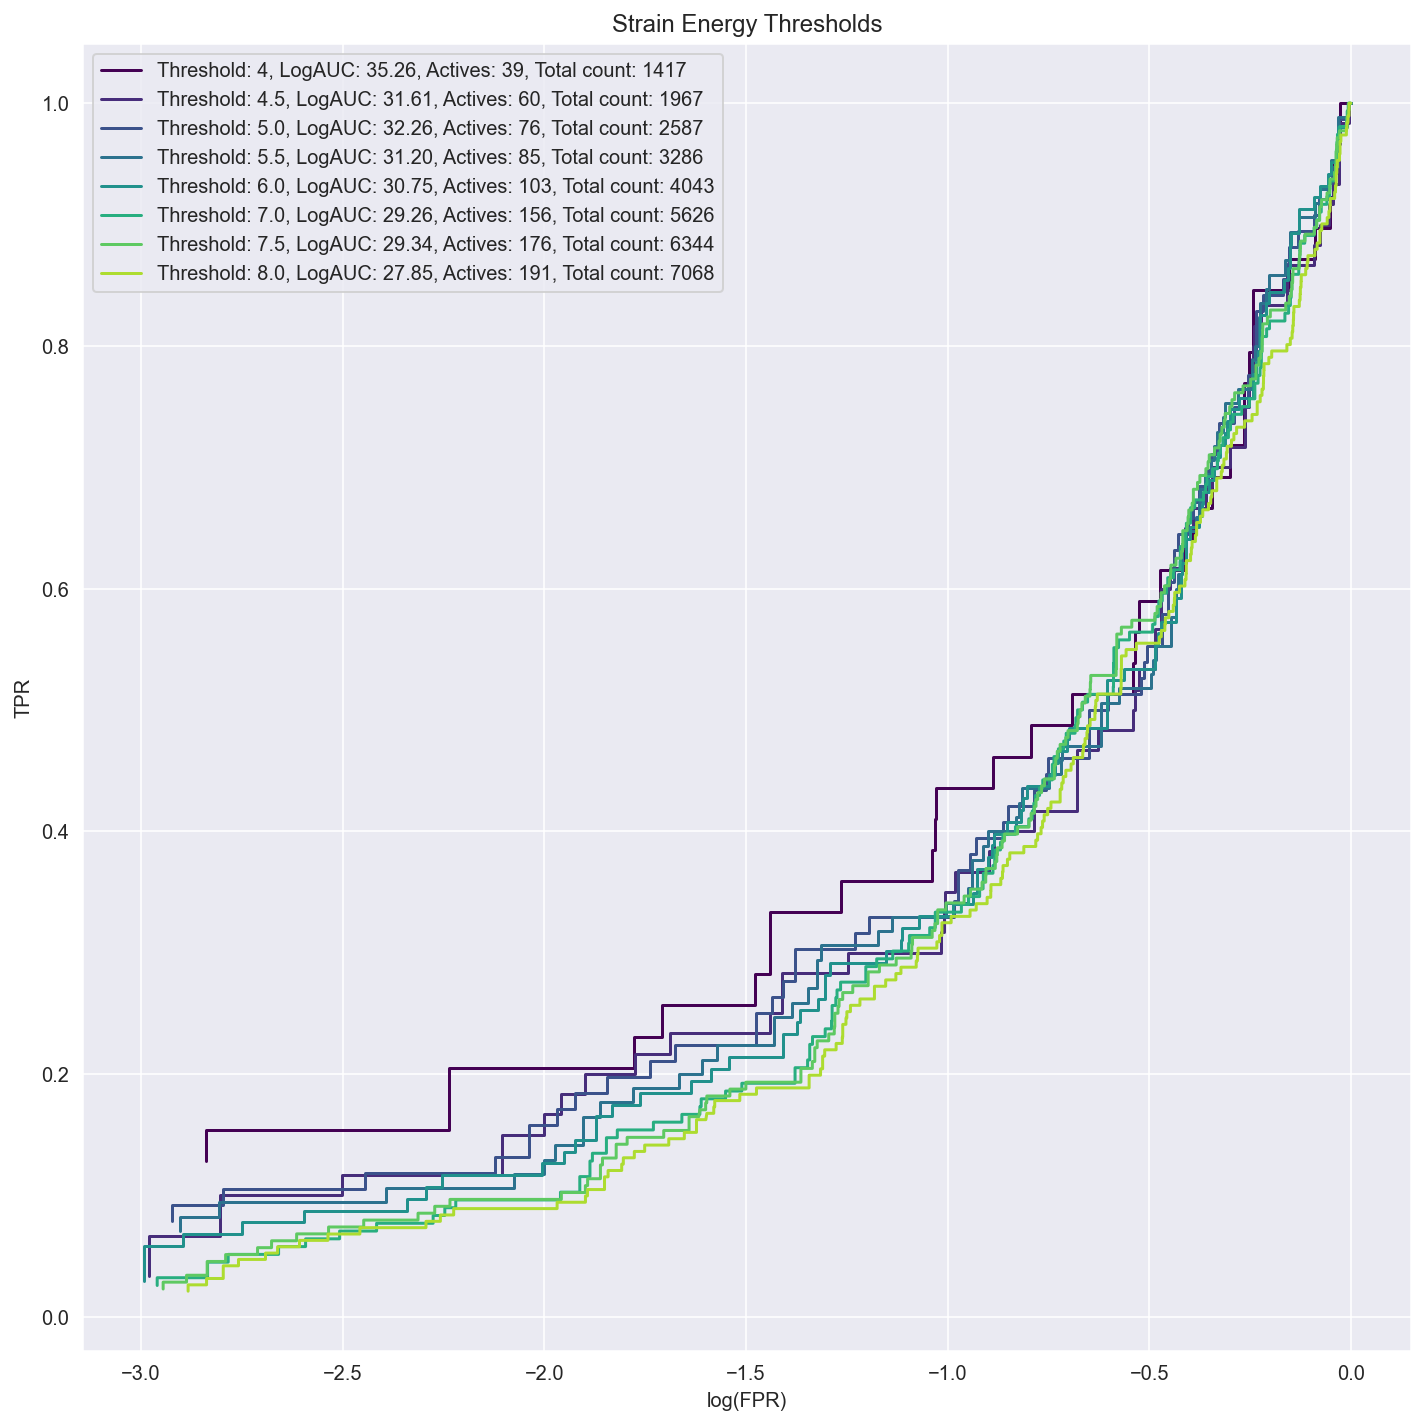

In [100]:
import matplotlib.cm as cm

def plot_semi_log_roc(df, a=1e-3, total_e_threshold=None, ax=None, color='blue'):
    # Filter dataframe based on 'Total_E' threshold if provided
    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    # Invert scores since lower scores indicate positive class
    y_scores_inverted = -df["r_i_docking_score"]

    # Calculate FPR, TPR, and thresholds using sklearn
    fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

    # Select the thresholds that result in FPR >= a for log scale plotting
    valid_indices = np.where(fpr >= a)
    fpr_valid = fpr[valid_indices]
    tpr_valid = tpr[valid_indices]

    # Calculate log of FPR for valid indices
    log_fpr_valid = np.log10(fpr_valid)

    # Calculate LogAUC
    log_auc = (auc(log_fpr_valid, tpr_valid) / -np.log10(a)) * 100

    # Count the number of rows with Activity = 1 and the total number of rows
    activity_1_count = df[df["Activity"] == 1].shape[0]
    total_count = df.shape[0]

    # Plot semi-log ROC curve
    ax.plot(
        log_fpr_valid,
        tpr_valid,
        label=f"Threshold: {total_e_threshold}, LogAUC: {log_auc:.2f}, Actives: {activity_1_count}, Total count: {total_count}",
        color=color
    )
    ax.legend()

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 10))

# Calculate log_auc for no filtering
fpr_none, tpr_none, _ = roc_curve(
    adrb1_all_data["Activity"], -adrb1_all_data["r_i_docking_score"]
)
valid_indices_none = np.where(fpr_none >= 1e-3)
auc_none = auc(np.log10(fpr_none[valid_indices_none]), tpr_none[valid_indices_none])
log_auc_none = (auc_none / -np.log10(1e-3)) * 100

# Define a colormap
cmap = cm.get_cmap('viridis', len(total_e_thresholds))

# Plot semi-log ROC curve for each threshold
for i, t in enumerate(total_e_thresholds[1:]):
    # Filter dataframe based on 'Total_E' threshold
    df_filtered = adrb1_all_data[adrb1_all_data["Total_E"] <= t]

    # Call the function with the filtered data
    plot_semi_log_roc(df_filtered, total_e_threshold=t, ax=ax, color=cmap(i))

ax.set_title("Strain Energy Thresholds")
ax.set_xlabel("log(FPR)")
ax.set_ylabel("TPR")

plt.tight_layout()
plt.show()

In [101]:
import matplotlib.cm as cm

def plot_semi_log_roc(df, a=1e-3, total_e_threshold=None, ax=None, color='blue'):
  # Filter dataframe based on 'Total_E' threshold if provided
  if total_e_threshold is not None:
    df = df[df["Total_E"] <= total_e_threshold]

  # Invert scores since lower scores indicate positive class
  y_scores_inverted = -df["r_i_docking_score"]

  # Calculate FPR, TPR, and thresholds using sklearn
  fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

  # Select the thresholds that result in FPR >= a for log scale plotting
  valid_indices = np.where(fpr >= a)
  fpr_valid = fpr[valid_indices]
  tpr_valid = tpr[valid_indices]

  # Calculate log of FPR for valid indices
  log_fpr_valid = np.log10(fpr_valid)

  # Calculate LogAUC
  log_auc = (auc(log_fpr_valid, tpr_valid) / -np.log10(a)) * 100

  # Count the number of rows with Activity = 1 and the total number of rows
  activity_1_count = df[df["Activity"] == 1].shape[0]
  total_count = df.shape[0]

  # Plot semi-log ROC curve
  ax.plot(
    log_fpr_valid,
    tpr_valid,
    label=f"Threshold: {total_e_threshold if total_e_threshold is not None else 'N/A'}, LogAUC: {log_auc:.2f}, Actives: {activity_1_count}, Total count: {total_count}",
    color=color
  )
  ax.legend()


In [102]:
def plot_all_thresholds(data, thresholds):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Define a colormap
    cmap = cm.get_cmap('viridis', len(thresholds))

    # Plot semi-log ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Filter dataframe based on 'Total_E' threshold
        df_filtered = data if t is None else data[data["Total_E"] <= t]

        # Call the function with the filtered data
        plot_semi_log_roc(df_filtered, total_e_threshold=t, ax=ax, color=cmap(i))

    ax.set_title("Strain Energy Thresholds")
    ax.set_xlabel("log(FPR)")
    ax.set_ylabel("TPR")

    plt.tight_layout()
    plt.show()

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_43724/1804487911.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(thresholds))


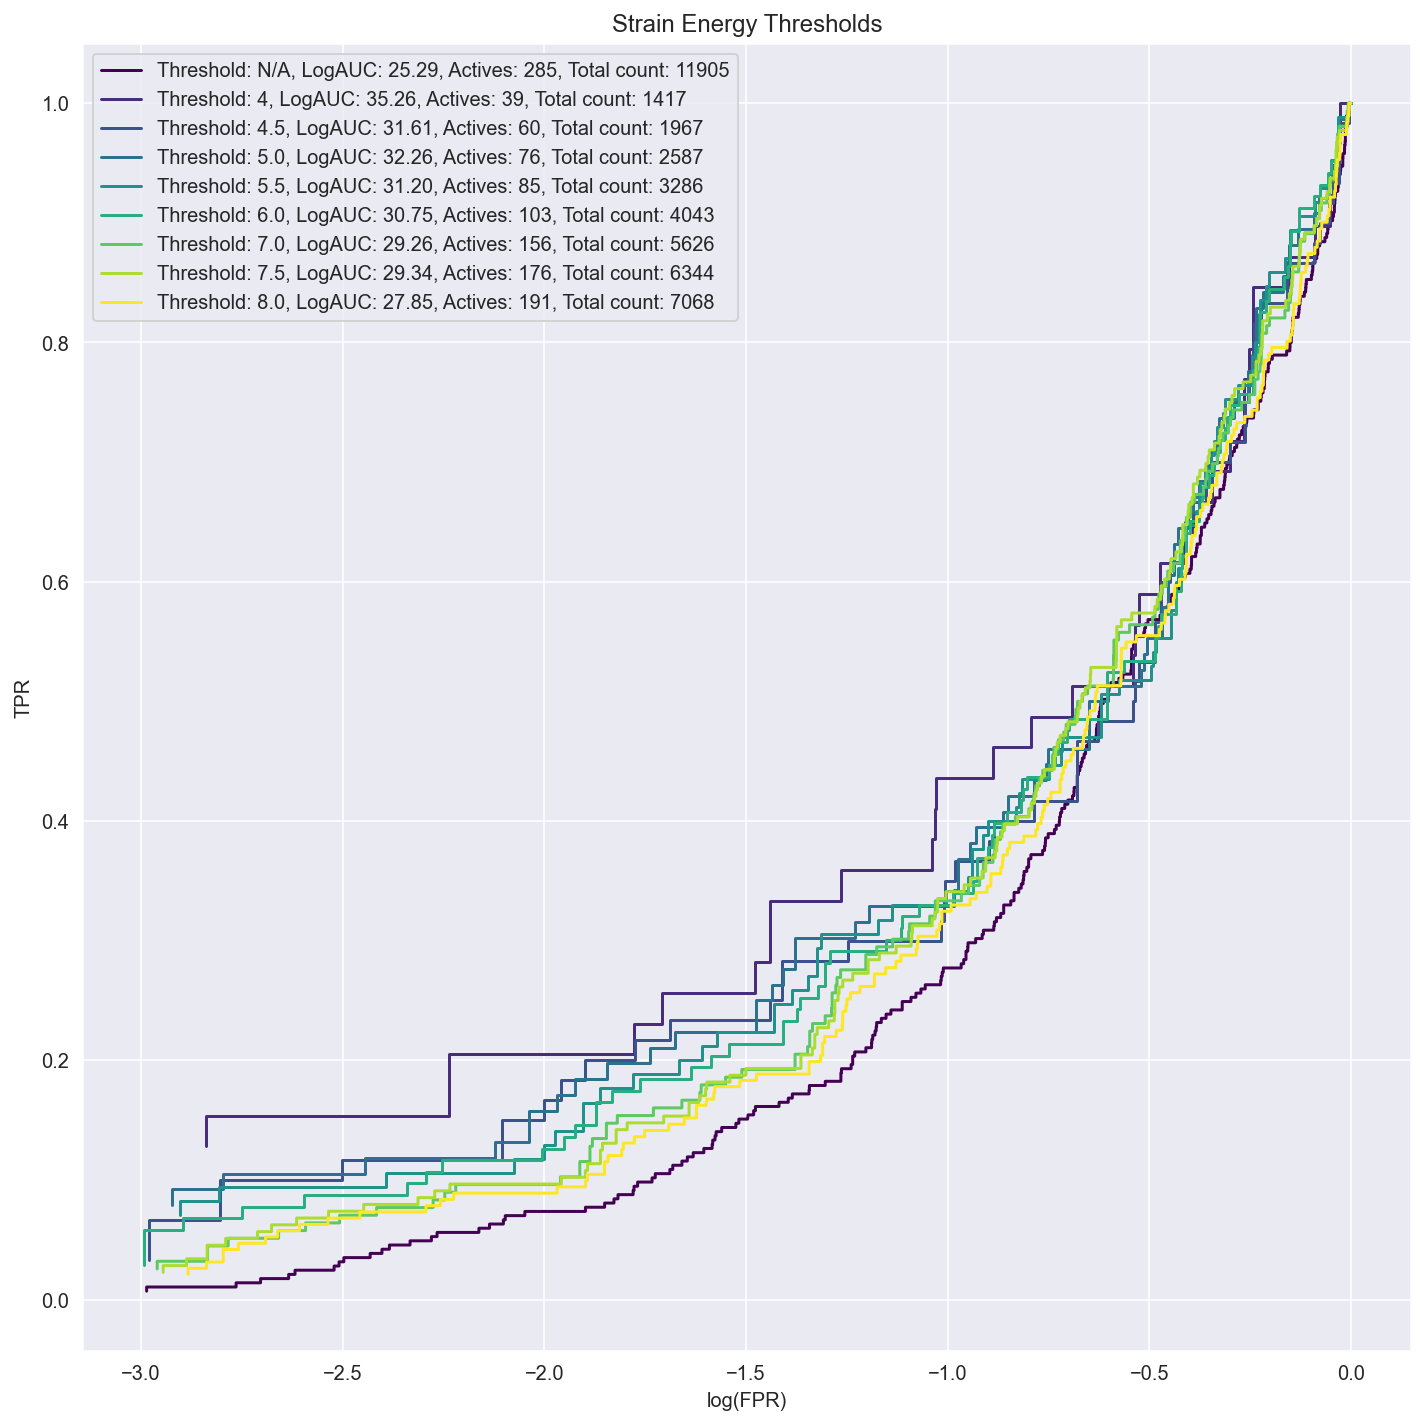

In [103]:
plot = plot_all_thresholds(adrb1_all_data, total_e_thresholds)

In [111]:
def logauc_by_strain(df, a=1e-3, total_e_threshold=None):
    # Filter dataframe based on 'Total_E' threshold if provided
    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    # Invert scores since lower scores indicate positive class
    y_scores_inverted = -df["r_i_docking_score"]

    # Calculate FPR, TPR, and thresholds using sklearn
    fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

    # Select the thresholds that result in FPR >= a for log scale plotting
    valid_indices = np.where(fpr >= a)
    fpr_valid = fpr[valid_indices]
    tpr_valid = tpr[valid_indices]

    # Calculate log of FPR for valid indices
    log_fpr_valid = np.log10(fpr_valid)

    # Calculate the AUC for the valid range
    linlog_auc = auc(log_fpr_valid, tpr_valid)
    log_auc = (linlog_auc / -np.log10(a)) * 100

    # Print the first X-axis value (logFPR)
    if len(log_fpr_valid) > 0:
        print(f"LogAUC for threshold {total_e_threshold}: {log_auc:.2f}")
        print(f"First X-axis value (logFPR): {log_fpr_valid[0]}")
    else:
        print("No valid logFPR values")

    return log_auc

In [112]:
log_aucs = [logauc_by_strain(adrb1_all_data, total_e_threshold=t) for t in total_e_thresholds]


LogAUC for threshold None: 25.29
First X-axis value (logFPR): -2.9860248820066873
LogAUC for threshold 4: 35.26
First X-axis value (logFPR): -2.8382192219076257
LogAUC for threshold 4.5: 31.61
First X-axis value (logFPR): -2.9793206973820245
LogAUC for threshold 5.0: 32.26
First X-axis value (logFPR): -2.92272545799326
LogAUC for threshold 5.5: 31.20
First X-axis value (logFPR): -2.9032256828161698
LogAUC for threshold 6.0: 30.75
First X-axis value (logFPR): -2.9934362304976116
LogAUC for threshold 7.0: 29.26
First X-axis value (logFPR): -2.959836075949787
LogAUC for threshold 7.5: 29.34
First X-axis value (logFPR): -2.9450463250286436
LogAUC for threshold 8.0: 27.85
First X-axis value (logFPR): -2.8831565149026974


In [124]:
def debug_logauc_by_strain(df, a=1e-3, total_e_threshold=None):
    # Filter dataframe based on 'Total_E' threshold if provided
    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    # Invert scores since lower scores indicate positive class
    y_scores_inverted = -df["r_i_docking_score"]

    # Calculate FPR, TPR, and thresholds using sklearn
    fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

    # Select the thresholds that result in FPR >= a for log scale plotting
    valid_indices = np.argmax(fpr >= a)
    print(f"Valid indices for threshold {total_e_threshold}: {valid_indices}")
    fpr_valid = fpr[valid_indices]
    tpr_valid = tpr[valid_indices]

    # Calculate log of FPR for valid indices
    log_fpr_valid = np.log10(fpr_valid)

    # Calculate the AUC for the valid range
    linlog_auc = auc(log_fpr_valid, tpr_valid)
    log_auc = (linlog_auc / -np.log10(a)) * 100

    # Print the first X-axis value (logFPR)
    if len(log_fpr_valid) > 0:
        print(f"LogAUC for threshold {total_e_threshold}: {log_auc:.2f}")
        print(f"First X-axis value (logFPR): {log_fpr_valid[0]}")
    else:
        print("No valid logFPR values")

    return log_auc

log_aucs = [
    debug_logauc_by_strain(adrb1_all_data, total_e_threshold=t)
    for t in total_e_thresholds
]

Valid indices for threshold None: 6


TypeError: Singleton array -2.9860248820066873 cannot be considered a valid collection.

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_43724/1407822510.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(thresholds))


AUC for random classifier: 0.1453719815687066


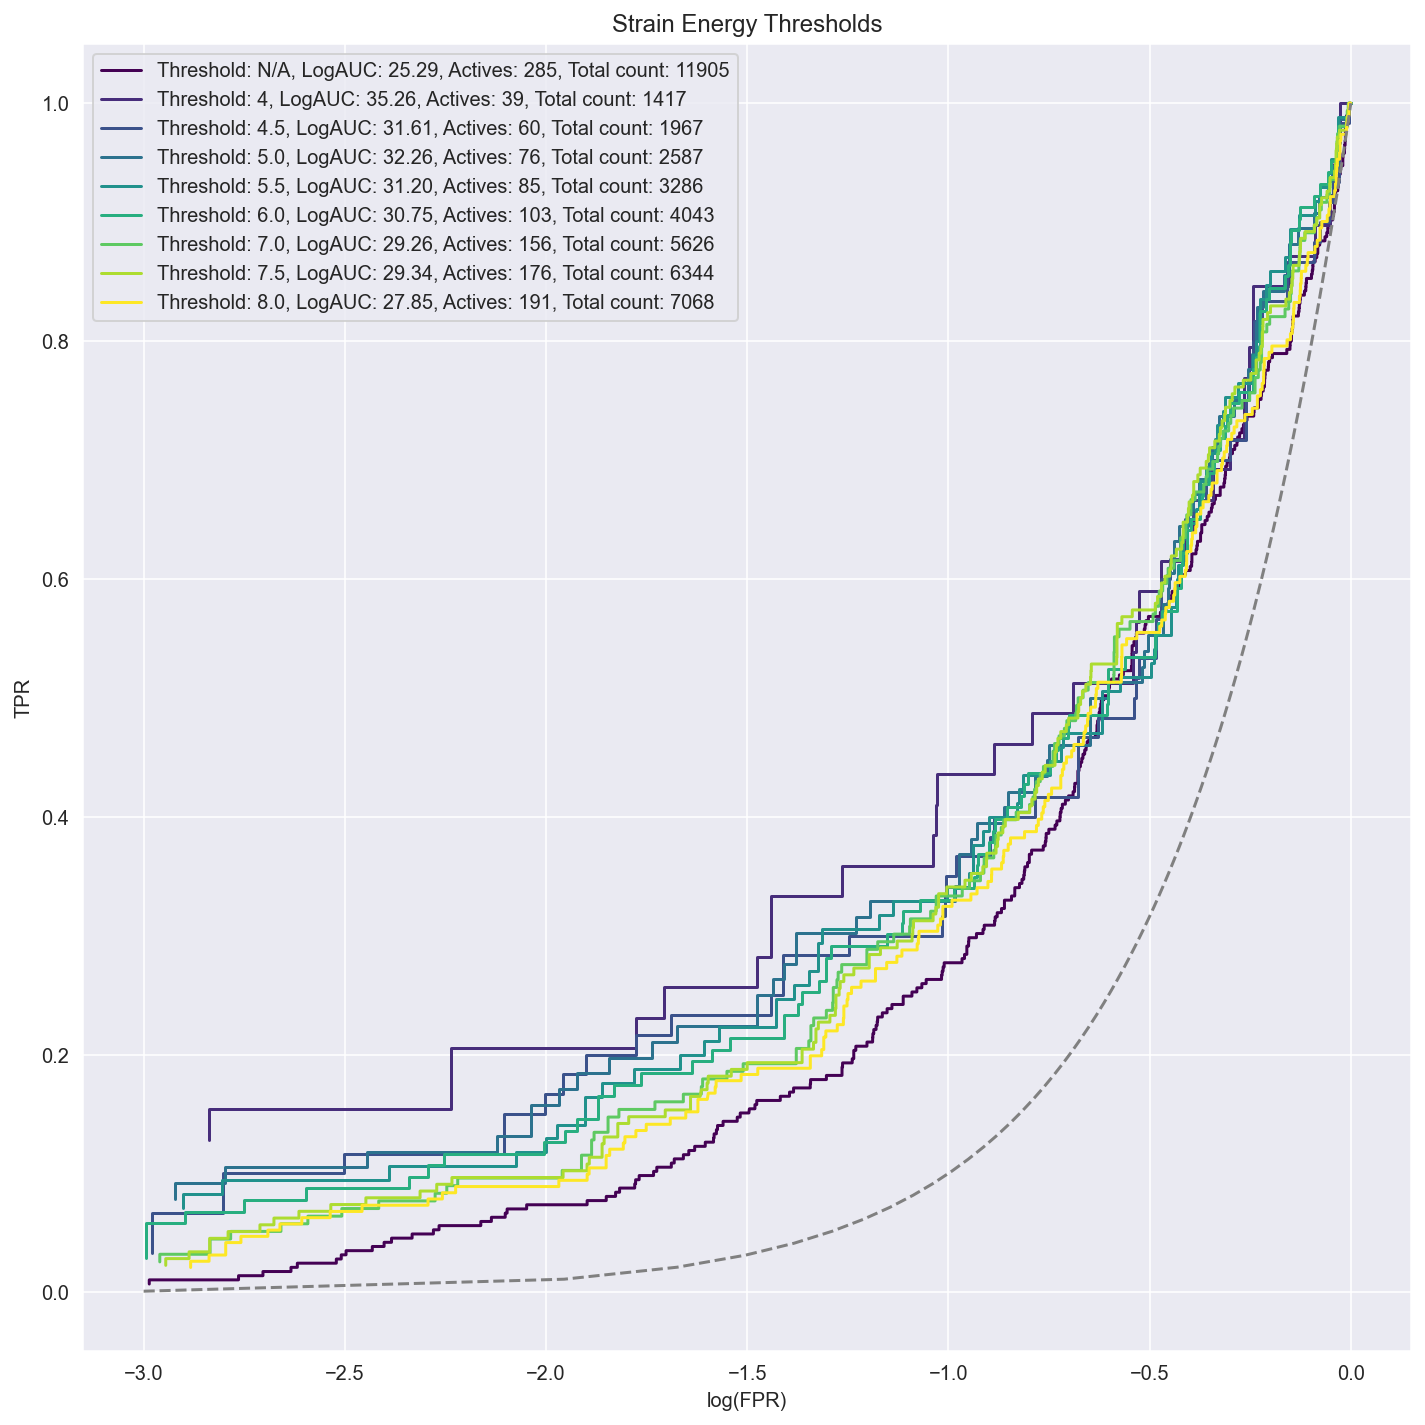

In [127]:
# losing my mind

def debug_plot_all_thresholds(data, thresholds, a=1e-3):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Define a colormap
    cmap = cm.get_cmap('viridis', len(thresholds))

    # Plot semi-log ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Filter dataframe based on 'Total_E' threshold
        df_filtered = data if t is None else data[data["Total_E"] <= t]

        # Call the function with the filtered data
        plot_semi_log_roc(df_filtered, total_e_threshold=t, ax=ax, color=cmap(i))

    # Define the points for the random classifier
    x_values_random_class = np.linspace(a, 1, 100)
    y_values_random_class = x_values_random_class  # For a random classifier, the true positive rate equals the false positive rate

    # Apply a logarithmic transformation to the x values
    x_values_log = np.log10(x_values_random_class)

    # Plot the random classifier
    ax.plot(x_values_log, y_values_random_class, linestyle='--', color='grey')

    # Calculate the AUC for the random classifier
    linlog_auc_random = auc(x_values_log, y_values_random_class)
    log_auc_random = linlog_auc_random / -np.log10(a)

    print(f"AUC for random classifier: {log_auc_random}")

    ax.set_title("Strain Energy Thresholds")
    ax.set_xlabel("log(FPR)")
    ax.set_ylabel("TPR")

    plt.tight_layout()
    plt.show()

debug_plot = debug_plot_all_thresholds(adrb1_all_data, total_e_thresholds)